In [1]:
from PIL import Image
from IPython.display import SVG, display, clear_output
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision.transforms as T

from src.ShapeRenderer import ShapeRenderer
from src.ShapeRendererSVG import ShapeRendererSVG
from src.utils import unnormalize_functional, rgb_to_rgba, rgba_to_rgb, unnormalize_to
from src.models import Model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_size = 128
n_shapes = 16
image_path = r"./media/sample_images/sample_image1.png"

mean = [0.5, 0.5, 0.5]
std = [0.225, 0.225, 0.225]

transforms = T.Compose([
    T.Resize(image_size),
    T.CenterCrop((image_size,image_size)),
    T.ToTensor(),
    T.Normalize(mean, std),
])

target_tensor = transforms(Image.open(image_path).convert("RGB")).to(device)
renderer = ShapeRenderer(device=device, imsize=image_size, minimum_sharpness=10).to(device)

parameters = Model.grid_init(n_shapes=n_shapes, n_parameter_fields=11).to(device)
parameters = Variable(parameters, requires_grad = True)

def criterion(pred_image, target):
    rgba_target = rgb_to_rgba(target)

    return torch.nn.functional.l1_loss(pred_image, rgba_target)

C:\Users\Simon\Anaconda3\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
losses = []

In [4]:
lr = 1e-2
optimizer = optim.Adam([parameters], lr=lr, betas=(0.5, 0.999))

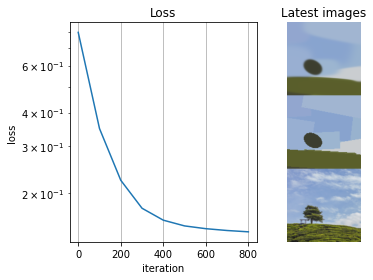

KeyboardInterrupt: 

In [5]:
for i in range(20000+1):
    # "Train"
    optimizer.zero_grad()
    output_tensor = renderer(torch.sigmoid(parameters.unsqueeze(0))).squeeze(0)
    loss = criterion(output_tensor, target_tensor)
    loss.backward()
    optimizer.step()

    # Log
    if i % 100 == 0:
        losses.append(loss.item())
        renderer.eval()
        output_tensor_crisp = renderer(torch.sigmoid(parameters.unsqueeze(0))).squeeze(0)
        renderer.train()

        input_img = unnormalize_functional(target_tensor, mean, std)
        output_img = unnormalize_functional(rgba_to_rgb(output_tensor), mean, std)
        output_img_crip = unnormalize_functional(rgba_to_rgb(output_tensor_crisp), mean, std)

        combined_image = torch.concat([output_img, output_img_crip, input_img], -2)
        # print(f"i: {i}\tloss: {loss}")
        fig = plt.figure()
        fig.add_subplot(121)
        plt.plot(np.linspace(0, i, len(losses)), losses)
        plt.xlabel("iteration")
        plt.ylabel("loss")
        plt.title("Loss")
        plt.yscale("log")
        plt.grid()

        fig.add_subplot(122)
        plt.axis('off')
        plt.imshow(combined_image.cpu().detach().numpy().transpose(1, 2, 0))
        plt.title("Latest images")

        fig.tight_layout()
        clear_output(wait=True)
        plt.show()

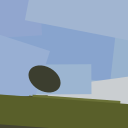

In [6]:
from src.ShapeRendererSVG import ShapeRendererSVG

svg_renderer = ShapeRendererSVG(renderer, canvas_size=128, mean=mean, std=std)
svg_renderer.save_png(torch.sigmoid(parameters), "./media/sample_images_abstracted/sample_image1_abstracted.png")
svg_renderer.to_pil_image(torch.sigmoid(parameters))